# **LendingClub Credit Risk and Pricing Analysis**

This notebook presents the empirical analysis for our LendingClub fintech project. We use loan‑level data on consumer instalment loans originated through the LendingClub platform to study how credit risk is priced and screened in an online lending environment. The analysis focuses on completed loans, where default or full repayment has already been observed, so that model performance can be evaluated against realized outcomes.

Our objectives are to:
- construct a clean, model‑ready dataset from the raw LendingClub files;
- estimate default probabilities (PDs) using borrower, loan, and credit‑history information;
- assess whether LendingClub’s pricing (interest rates) increases appropriately with risk;
- evaluate the effectiveness of key underwriting variables (FICO, DTI, income, verification, etc.);
- compare risk‑adjusted performance across major borrower segments to inform portfolio strategy.



# **Notebook structure**

1. **Setup and data loading**  
   * Import Python libraries and load the raw LendingClub loan data.

2. **Data cleaning and feature engineering**  
   - Define a binary default outcome (`default_binary`) and filter to completed loans.  
   - Select core modelling features and engineer `credit_history_months`.  
   - Encode ordinal and categorical variables into a fully numeric dataset.

3. **Risk‑based pricing and PD deciles**  
   - Fit a logistic regression model to estimate PD for each loan.  
   - Form PD deciles and relate default rates, interest rates, and expected returns.

4. **Underwriting effectiveness and policy simulation**  
   - Estimate a multivariate logit model on key underwriting variables.  
   - Interpret odds ratios and simulate a tighter policy (dropping highest‑risk loans).

5. **Segment performance**  
   - Compare default, pricing, and expected returns by loan purpose and home‑ownership.  
   - Highlight segments that appear over‑ or under‑priced.

6. **Exports for report**  
   - Save summary tables and figures for inclusion in the written report and slides.




# **Importing necessary Libraries**

In [ ]:
# Importing necessary libraries

# System and file utilities
import os

# Data manipulation and numerical computing
import numpy as np
import pandas as pd

# Accessing the LendingClub dataset from Kaggle
import kagglehub

# Machine learning models and train/test split
from sklearn.linear_model import LogisticRegression      # for PD (default) prediction
from sklearn.model_selection import train_test_split     # to create train/test samples

# Statistical modelling (for odds ratios, detailed regression output)
import statsmodels.api as sm

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# **Introduction and data source**

### Data source and loading

The quantitative analysis uses the public LendingClub loan‑level dataset from Kaggle (“wordsforthewise/lending-club”), which contains all accepted loan applications from 2007 to 2018Q4. This dataset is widely used in academic and industry research and provides detailed borrower, loan, and performance information, making it suitable for studying default risk, pricing, and underwriting at LendingClub. In this section the raw data is downloaded directly from Kaggle, the main accepted‑loan file is loaded, and a quick preview is shown to verify that the import worked as expected.


In [ ]:
# Download and load LendingClub data from Kaggle

# 1. Download the latest version of the dataset to the local cache
path = kagglehub.dataset_download("wordsforthewise/lending-club")
print("Path to dataset files:", path)

# 2. Inspect available files in the downloaded folder
print(os.listdir(path))  # should include accepted_2007_to_2018Q4.csv or .csv.gz

# 3. Load the main accepted‑loans file (gzipped CSV)
file_name = "accepted_2007_to_2018Q4.csv.gz"
file_path = os.path.join(path, file_name)

df = pd.read_csv(file_path, low_memory=False)
print("Raw dataset shape (rows, columns):", df.shape)

# 4. Preview a few rows to confirm successful loading
df.head(10)


Using Colab cache for faster access to the 'lending-club' dataset.
Path to dataset files: /kaggle/input/lending-club
['rejected_2007_to_2018Q4.csv.gz', 'accepted_2007_to_2018Q4.csv.gz', 'accepted_2007_to_2018q4.csv', 'rejected_2007_to_2018q4.csv']
Raw dataset shape (rows, columns): (2260701, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,68426831,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,68476668,NaN,20000.0,20000.0,20000.0,36 months,9.17,637.58,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,67275481,NaN,20000.0,20000.0,20000.0,36 months,8.49,631.26,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
8,68466926,NaN,10000.0,10000.0,10000.0,36 months,6.49,306.45,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,68616873,NaN,8000.0,8000.0,8000.0,36 months,11.48,263.74,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


The raw LendingClub file contains 151 columns covering borrower characteristics, loan terms, and performance outcomes. Before selecting features for modelling, the code below prints the column names to get an overview of what information is available and to guide variable selection for the default‑risk analysis.


In [ ]:
# Print the full list of column names in the raw dataset

print("Total number of columns:", len(df.columns))
for i, col in enumerate(df.columns, start=1):
    print(f"{i:3d}. {col}")


Total number of columns: 151
  1. id
  2. member_id
  3. loan_amnt
  4. funded_amnt
  5. funded_amnt_inv
  6. term
  7. int_rate
  8. installment
  9. grade
 10. sub_grade
 11. emp_title
 12. emp_length
 13. home_ownership
 14. annual_inc
 15. verification_status
 16. issue_d
 17. loan_status
 18. pymnt_plan
 19. url
 20. desc
 21. purpose
 22. title
 23. zip_code
 24. addr_state
 25. dti
 26. delinq_2yrs
 27. earliest_cr_line
 28. fico_range_low
 29. fico_range_high
 30. inq_last_6mths
 31. mths_since_last_delinq
 32. mths_since_last_record
 33. open_acc
 34. pub_rec
 35. revol_bal
 36. revol_util
 37. total_acc
 38. initial_list_status
 39. out_prncp
 40. out_prncp_inv
 41. total_pymnt
 42. total_pymnt_inv
 43. total_rec_prncp
 44. total_rec_int
 45. total_rec_late_fee
 46. recoveries
 47. collection_recovery_fee
 48. last_pymnt_d
 49. last_pymnt_amnt
 50. next_pymnt_d
 51. last_credit_pull_d
 52. last_fico_range_high
 53. last_fico_range_low
 54. collections_12_mths_ex_med
 55. mths

## Interpretation
* Contains over one million LendingClub loans with 151 raw variables.

* Application and loan terms: loan amount, term, interest rate, installment, grade/subgrade, employment information, income, purpose, state, and debt‑to‑income ratio.

* Credit history: FICO scores, earliest credit line, delinquencies, inquiries, number of open/total accounts, utilization ratios, and credit limits.

* Performance and payoff: loan status, outstanding principal, total payments, interest and principal received, late fees, recoveries, and write‑offs.

* Joint applicant and secondary borrower variables: joint income, joint DTI, joint verification status, and secondary FICO/credit history fields.

* Hardship and settlement information: hardship flags, payment plan details, settlement amounts and percentages, and related dates, capturing loan restructuring events.

# **Data cleaning and feature engineering**

## Dropping columns with high missingness
To simplify the dataset and avoid unreliable variables, columns with more than 30% missing observations are removed. This keeps the focus on well‑populated features that can be used reliably in the modelling step.

In [ ]:
# 2.1 Drop columns with more than 30% missing values

# Calculate the fraction of missing values for each column
missing_pct = df.isnull().sum() / len(df)

# Identify columns where more than 30% of observations are missing
cols_to_drop = missing_pct[missing_pct > 0.30].index.tolist()
print(f"Number of columns dropped due to >30% missing: {len(cols_to_drop)}")

# Optionally preview a few of the dropped columns
print("Example dropped columns:", cols_to_drop[:10])

# Drop the identified columns from the DataFrame
n_cols_before = df.shape[1]
df = df.drop(columns=cols_to_drop).copy()
n_cols_after = df.shape[1]

print(f"Original number of columns: {n_cols_before}")
print(f"Number of columns after dropping: {n_cols_after}")
print("Current dataset shape (rows, columns):", df.shape)


Number of columns dropped due to >30% missing: 58
Example dropped columns: ['member_id', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m']
Original number of columns: 151
Number of columns after dropping: 93
Current dataset shape (rows, columns): (2260701, 93)


## Constructing `default_binary`
LendingClub reports many loan statuses. For modelling, these are collapsed into a binary outcome: 1 for loans that defaulted or were charged off, and 0 for loans that were fully paid. All other statuses (for example, current or in‑grace‑period) are treated as missing and removed later.

In [ ]:
# Define which loan_status values count as default (1)
default_list = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Charged Off"
]

# Define which loan_status values count as fully paid (0)
paid_list = [
    "Fully Paid",
    "Does not meet the credit policy. Status:Fully Paid"
]

def map_loan_status(status):
    """
    Map LendingClub loan_status to:
    1 = default / charged off
    0 = fully paid
    NaN = ongoing or other intermediate status
    """
    if status in default_list:
        return 1
    elif status in paid_list:
        return 0
    else:
        return np.nan  # e.g. 'Current', 'In Grace Period', 'Late', etc.

# Apply the mapping to create the binary target variable
df["default_binary"] = df["loan_status"].apply(map_loan_status)


## Filtering to completed loans
The analysis focuses on loans with a resolved outcome. Loans whose status is still in progress are dropped so that the target variable is well defined.

In [ ]:
# Store original number of observations
original_rows = len(df)

# Drop rows where default_binary is NaN (loans without resolved outcome)
df = df.dropna(subset=["default_binary"]).copy()

# Ensure the target is stored as integer (0 or 1)
df["default_binary"] = df["default_binary"].astype(int)

print(f"Dropped {original_rows - len(df)} non‑completed loans.")
print(f"Remaining completed loans for modelling: {len(df)}")

# Check the proportion of defaults vs fully paid loans
print(df["default_binary"].value_counts(normalize=True))


Dropped 912602 non‑completed loans.
Remaining completed loans for modelling: 1348099
default_binary
0    0.800193
1    0.199807
Name: proportion, dtype: float64


## Selecting core predictors
From the 151 raw variables, a focused set of predictors is chosen to capture loan terms, traditional credit‑risk information, fintech profile variables, and timing needed to build credit‑history length. These variables form the starting point for later cleaning and feature engineering.

In [ ]:
# Target column for the model
target_col = ["default_binary"]

# List of predictor variables selected from the raw dataset
model_features = [
    # Core loan terms describing contract characteristics
    "loan_amnt",          # requested loan amount
    "term",               # loan term (e.g. 36 or 60 months)
    "int_rate",           # interest rate charged
    "grade",              # LendingClub internal credit grade
    "purpose",            # stated loan purpose

    # Traditional credit‑risk profile variables
    "fico_range_low",     # lower bound of FICO score range
    "earliest_cr_line",   # date of first reported credit line
    "pub_rec",            # number of derogatory public records
    "pub_rec_bankruptcies",  # number of public record bankruptcies

    # Fintech / borrower profile variables
    "annual_inc",         # self‑reported annual income
    "verification_status",# income verification flag
    "emp_length",         # employment length in years (to be cleaned)
    "home_ownership",     # home ownership type
    "dti",                # debt‑to‑income ratio
    "revol_util",         # revolving line utilization
    "open_acc",           # number of open credit lines
    "total_acc",          # total number of credit lines
    "mort_acc",           # number of mortgage accounts
    "tot_cur_bal",        # total current balance of all accounts
    "total_rev_hi_lim",   # total revolving high credit/credit limit
    "bc_util",            # utilization of bankcard accounts
    "total_bal_ex_mort",  # total balance excluding mortgage

    # Timing variable needed for credit history length
    "issue_d"             # month/year the loan was issued
]

# Combine target and features into a single modelling DataFrame
columns_to_keep = target_col + model_features
df_model = df[columns_to_keep].copy()

print("\n--- Initial modelling DataFrame ---")
df_model.info()



--- Initial modelling DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 1348099 entries, 0 to 2260697
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   default_binary        1348099 non-null  int64  
 1   loan_amnt             1348099 non-null  float64
 2   term                  1348099 non-null  object 
 3   int_rate              1348099 non-null  float64
 4   grade                 1348099 non-null  object 
 5   purpose               1348099 non-null  object 
 6   fico_range_low        1348099 non-null  float64
 7   earliest_cr_line      1348070 non-null  object 
 8   pub_rec               1348070 non-null  float64
 9   pub_rec_bankruptcies  1346734 non-null  float64
 10  annual_inc            1348095 non-null  float64
 11  verification_status   1348099 non-null  object 
 12  emp_length            1269549 non-null  object 
 13  home_ownership        1348099 non-null  object 
 14  dt

## Creating `credit_history_months`
Borrower credit history is a key risk driver. To capture it in a single numeric variable, the code below computes the number of months between the borrower’s earliest reported credit line and the loan issue date. Any missing values are set to zero, and the original date columns are dropped after the new feature is created.

In [ ]:
print("--- Creating 'credit_history_months' feature ---")

# 1. Ensure date columns are in datetime format
df_model["issue_d"] = pd.to_datetime(df_model["issue_d"], format="%b-%Y")
df_model["earliest_cr_line"] = pd.to_datetime(df_model["earliest_cr_line"], format="%b-%Y")

# 2. Difference between issue date and earliest credit line (in days)
time_diff_days = (df_model["issue_d"] - df_model["earliest_cr_line"]).dt.days

# 3. Convert days to months and handle missing values (rare)
credit_history_months = (time_diff_days / 30.44).fillna(0)

# 4. Store as integer number of months
df_model["credit_history_months"] = credit_history_months.astype(int)

print("\nSummary of 'credit_history_months':")
print(df_model["credit_history_months"].describe())

# 5. Drop the original date columns now that the numeric feature exists
cols_to_drop = ["earliest_cr_line", "issue_d"]
df_model = df_model.drop(columns=cols_to_drop)

print("\nDropped original date columns:", cols_to_drop)

# Final check on the updated DataFrame
print("\n--- DataFrame info after adding 'credit_history_months' ---")
df_model.info()


--- Creating 'credit_history_months' feature ---

Summary of 'credit_history_months':
count    1.348099e+06
mean     1.943054e+02
std      9.002958e+01
min      0.000000e+00
25%      1.340000e+02
50%      1.760000e+02
75%      2.390000e+02
max      9.980000e+02
Name: credit_history_months, dtype: float64

Dropped original date columns: ['earliest_cr_line', 'issue_d']

--- DataFrame info after adding 'credit_history_months' ---
<class 'pandas.core.frame.DataFrame'>
Index: 1348099 entries, 0 to 2260697
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   default_binary         1348099 non-null  int64  
 1   loan_amnt              1348099 non-null  float64
 2   term                   1348099 non-null  object 
 3   int_rate               1348099 non-null  float64
 4   grade                  1348099 non-null  object 
 5   purpose                1348099 non-null  object 
 6   fico_range_low         1

## Exploring key categorical and ordinal variables
Before encoding, it is useful to inspect the main categorical and ordinal fields used in the model. The code below shows a small sample of `term`, `grade`, `purpose`, `verification_status`, `emp_length`, and `home_ownership`, and reports how many distinct values each variable takes. This guides how they should be encoded (ordinal mapping versus one‑hot dummies).

In [ ]:
# Select the main categorical / ordinal variables to inspect
selected_columns = [
    "term",
    "grade",
    "purpose",
    "verification_status",
    "emp_length",
    "home_ownership"
]

# Show a few example rows for these variables
print("--- Head of selected columns ---")
display(df_model[selected_columns].head())

# Count the number of unique values for each selected variable
print("\n--- Unique value counts for selected columns ---")
for col in selected_columns:
    n_unique = df_model[col].nunique()
    print(f"{col}: {n_unique} unique values")


--- Head of selected columns ---


,term,grade,purpose,verification_status,emp_length,home_ownership
0,36 months,C,debt_consolidation,Not Verified,10+ years,MORTGAGE
1,36 months,C,small_business,Not Verified,10+ years,MORTGAGE
2,60 months,B,home_improvement,Not Verified,10+ years,MORTGAGE
4,60 months,F,major_purchase,Source Verified,3 years,MORTGAGE
5,36 months,C,debt_consolidation,Source Verified,4 years,RENT



--- Unique value counts for selected columns ---
term: 2 unique values
grade: 7 unique values
purpose: 14 unique values
verification_status: 3 unique values
emp_length: 11 unique values
home_ownership: 6 unique values


## Interpretation
The loan term takes only 2 distinct values (36 or 60 months), which supports treating it as an ordinal numeric variable rather than creating many dummies.

Credit grade has 7 ordered categories (A–G), confirming that it should be mapped to an ordinal score reflecting increasing risk rather than one‑hot encoded.

Loan purpose is relatively granular, with 14 categories, so one‑hot dummies are appropriate to capture differences across segments such as debt consolidation, small business, and home improvement.

Verification status has only 3 levels, which makes it straightforward to encode with a small set of dummies and to interpret screening effects.

Employment length is reported in 11 categories (from “< 1 year” to “10+ years”), which is consistent with mapping it into years of experience for modelling.

Home ownership has 6 categories, suggesting meaningful heterogeneity in borrower profiles that will be captured via dummy variables for each ownership type.

## Encoding ordinal and nominal variables
To make categorical information usable in regression models, ordinal variables (`term`, `grade`, `emp_length`) are mapped into meaningful numeric scales, while purely nominal variables (`purpose`, `verification_status`, `home_ownership`) are converted into dummy indicators using one‑hot encoding. This step produces a model‑ready dataset with only numeric features.

In [ ]:
# --- 1. Fix ordinal features (manual mapping) ---

# A) 'term': convert "36 months" / "60 months" to integers 36 / 60
df_model["term"] = (
    df_model["term"]
    .str.replace(" months", "", regex=False)
    .str.strip()
    .astype(int)
)

# B) 'grade': map credit grades A (best) to G (worst) onto an ordinal scale
grade_map = {
    "A": 7,
    "B": 6,
    "C": 5,
    "D": 4,
    "E": 3,
    "F": 2,
    "G": 1
}
df_model["grade"] = df_model["grade"].map(grade_map)

# C) 'emp_length': convert text categories to years of experience
emp_map = {
    "< 1 year": 0,
    "1 year": 1,
    "2 years": 2,
    "3 years": 3,
    "4 years": 4,
    "5 years": 5,
    "6 years": 6,
    "7 years": 7,
    "8 years": 8,
    "9 years": 9,
    "10+ years": 10
}
df_model["emp_length"] = df_model["emp_length"].map(emp_map)

# Replace any remaining missing employment lengths with 0 years
df_model["emp_length"] = df_model["emp_length"].fillna(0)

# --- 2. Fix nominal features (one‑hot encoding) ---

print("Cleaning 'purpose', 'verification_status', and 'home_ownership'...")

# Columns that should be expanded into dummy indicators
nominal_cols = ["purpose", "verification_status", "home_ownership"]

# Create dummy variables; drop_first=True avoids perfect multicollinearity
df_final = pd.get_dummies(df_model, columns=nominal_cols, drop_first=True)

# --- 3. Final check on the encoded dataset ---

print("\n--- Final, model‑ready DataFrame ---")
df_final.info()


Cleaning 'purpose', 'verification_status', and 'home_ownership'...

--- Final, model‑ready DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 1348099 entries, 0 to 2260697
Data columns (total 40 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   default_binary                       1348099 non-null  int64  
 1   loan_amnt                            1348099 non-null  float64
 2   term                                 1348099 non-null  int64  
 3   int_rate                             1348099 non-null  float64
 4   grade                                1348099 non-null  int64  
 5   fico_range_low                       1348099 non-null  float64
 6   pub_rec                              1348070 non-null  float64
 7   pub_rec_bankruptcies                 1346734 non-null  float64
 8   annual_inc                           1348095 non-null  float64
 9   emp_length                        

## Interpretation
* The model‑ready dataset contains about 1.35 million completed loans and 40 fully numeric variables, providing a strong basis for statistical analysis.

* Loan purpose, verification status, and home ownership have been successfully encoded into dummy (True/False) variables, so all categorical information is usable in models.

* Key credit‑risk drivers such as FICO score, income, DTI, utilization ratios, and credit_history_months are present, with only limited remaining missing values that will be handled in the final cleaning step.

## Removing remaining missing values
After encoding and feature engineering, a small share of observations still contains missing values in key numeric fields. To keep the modelling setup simple and transparent, rows with any remaining NaNs are dropped, leaving a fully complete dataset for the main analysis.

In [ ]:
print("--- BEFORE DROPPING ---")
print(f"Original number of rows: {len(df_final)}")
print(f"Total missing values: {df_final.isnull().sum().sum()}")

# 1. Keep only rows with no missing values in any column
df_complete_rows = df_final.dropna()

print("\n--- AFTER DROPPING ---")
print(f"New number of rows: {len(df_complete_rows)}")
print(f"Rows dropped: {len(df_final) - len(df_complete_rows)}")
print(f"Total remaining missing values: {df_complete_rows.isnull().sum().sum()}")

# 2. Final check on the cleaned, model‑ready dataset
print("\n--- Final, model‑ready DataFrame info ---")
df_complete_rows.info()


--- BEFORE DROPPING ---
Original number of rows: 1348099
Total missing values: 308002

--- AFTER DROPPING ---
New number of rows: 1263109
Rows dropped: 84990
Total remaining missing values: 0

--- Final, model‑ready DataFrame info ---
<class 'pandas.core.frame.DataFrame'>
Index: 1263109 entries, 0 to 2260697
Data columns (total 40 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   default_binary                       1263109 non-null  int64  
 1   loan_amnt                            1263109 non-null  float64
 2   term                                 1263109 non-null  int64  
 3   int_rate                             1263109 non-null  float64
 4   grade                                1263109 non-null  int64  
 5   fico_range_low                       1263109 non-null  float64
 6   pub_rec                              1263109 non-null  float64
 7   pub_rec_bankruptcies                 126

# Risk‑based pricing: linking PD, rates, and expected returns

This section estimates a logistic regression model to predict the probability of default (PD) for each loan using all features except the interest rate. Loans are then sorted into deciles of predicted PD. For each decile, the average interest rate, realized default rate, and an approximate expected return are computed to assess whether higher‑risk borrowers are charged higher rates and whether pricing is consistent with risk.


In [ ]:
# Use the fully cleaned 40‑column dataset
df = df_complete_rows.copy()

# 1) Define features and target (exclude int_rate from X so we can study pricing separately)
target = "default_binary"
exclude = ["default_binary", "int_rate"]
X = df.drop(columns=exclude)
y = df[target]

# 2) Train/test split for model estimation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Fit logistic regression to estimate PD
logit = LogisticRegression(max_iter=1000, n_jobs=-1)
logit.fit(X_train, y_train)

# 4) Predicted PD for each loan (using full dataset)
df["pd_hat"] = logit.predict_proba(X)[:, 1]

# 5) Create PD deciles: 1 = safest loans, 10 = riskiest loans
df["pd_decile"] = pd.qcut(df["pd_hat"], 10, labels=False) + 1

# Assumed loss‑given‑default (LGD)
LGD = 0.60

# 6) Summarize pricing and performance by PD decile
risk_table = (
    df.groupby("pd_decile")
      .agg(
          avg_pd      = ("pd_hat", "mean"),
          default_rate= ("default_binary", "mean"),
          avg_rate    = ("int_rate", "mean"),
          n_loans     = ("default_binary", "size")
      )
      .reset_index()
)

# Approximate expected return: interest rate minus expected loss
risk_table["exp_return"] = risk_table["avg_rate"] - risk_table["default_rate"] * LGD

# Save for inclusion in the report
risk_table.to_csv("risk_pricing_deciles.csv", index=False)

risk_table


,pd_decile,avg_pd,default_rate,avg_rate,n_loans,exp_return
0,1,0.073245,0.066518,8.974033,126311,8.934122
1,2,0.112197,0.098123,10.354402,126311,10.295528
2,3,0.134356,0.122594,11.253337,126311,11.179781
3,4,0.152321,0.145435,11.982432,126311,11.895171
4,5,0.168780,0.169574,12.616294,126311,12.514549
5,6,0.185929,0.194308,13.238083,126310,13.121498
6,7,0.206914,0.225705,13.953009,126311,13.817587
7,8,0.240698,0.263595,15.013189,126311,14.855032
8,9,0.315829,0.297915,16.365170,126311,16.186420
9,10,0.422778,0.436375,18.851651,126311,18.589826


## Visualization

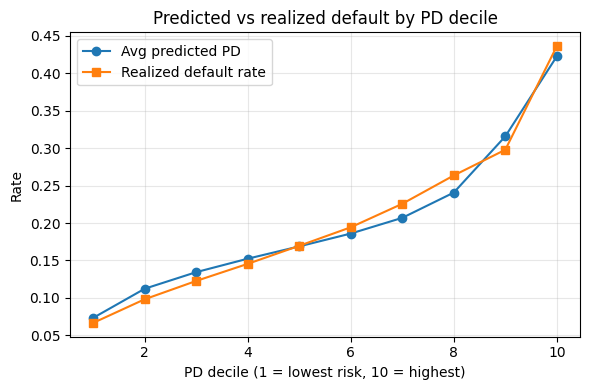

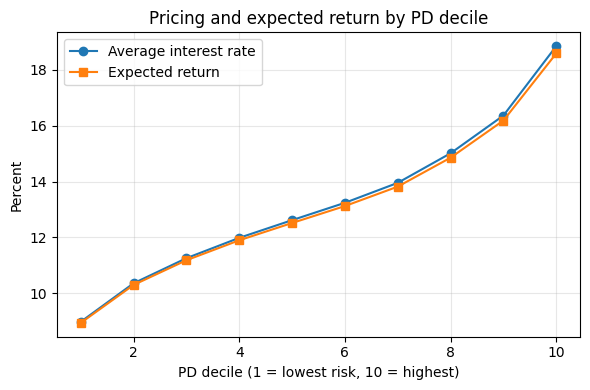

In [ ]:
import matplotlib.pyplot as plt

# Line plot: average PD and default rate by decile
fig, ax1 = plt.subplots(figsize=(6,4))

ax1.plot(risk_table["pd_decile"], risk_table["avg_pd"], marker="o", label="Avg predicted PD")
ax1.plot(risk_table["pd_decile"], risk_table["default_rate"], marker="s", label="Realized default rate")
ax1.set_xlabel("PD decile (1 = lowest risk, 10 = highest)")
ax1.set_ylabel("Rate")
ax1.grid(True, alpha=0.3)
ax1.legend()
plt.title("Predicted vs realized default by PD decile")
plt.tight_layout()
plt.show()

# Line plot: average interest rate and expected return by decile
fig, ax2 = plt.subplots(figsize=(6,4))

ax2.plot(risk_table["pd_decile"], risk_table["avg_rate"], marker="o", label="Average interest rate")
ax2.plot(risk_table["pd_decile"], risk_table["exp_return"], marker="s", label="Expected return")
ax2.set_xlabel("PD decile (1 = lowest risk, 10 = highest)")
ax2.set_ylabel("Percent")
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.title("Pricing and expected return by PD decile")
plt.tight_layout()
plt.show()


## Interpretation
* Predicted and realized default rates move almost one‑for‑one across PD deciles, rising from about 7% in the safest decile to over 40% in the riskiest, which shows that the model’s risk ranking aligns closely with actual outcomes.

* Average interest rates increase steadily with risk, from roughly 9% in the lowest‑risk decile to about 19% in the highest‑risk decile, indicating that LendingClub charges meaningfully higher prices to riskier borrowers.

* Expected returns (interest minus loss‑given‑default × default rate) also rise with PD, from around 9% to almost 19%, suggesting that higher‑risk loans are not only priced with higher rates but may actually deliver higher risk‑adjusted returns, implying conservative or profitable pricing in the riskiest segments.

# **Underwriting effectiveness and screening**

## Multivariate logistic regression for underwriting effectiveness

To evaluate how well LendingClub’s underwriting screens credit risk, a multivariate logistic regression is estimated with `default_binary` as the dependent variable and a focused set of predictors (excluding the interest rate) as regressors, including FICO score, debt‑to‑income ratio, income, employment length, credit‑history months, verification flags, and home‑ownership indicators.


In [ ]:
import numpy as np
import statsmodels.api as sm

df = df_complete_rows.copy()

# Start from the same X as before: drop target and int_rate
X_full = df.drop(columns=["default_binary", "int_rate"])

# Convert boolean dummies to 0/1 integers
for col in X_full.select_dtypes(include="bool").columns:
    X_full[col] = X_full[col].astype(int)

# To reduce collinearity, keep only a focused set of underwriting variables
underwriting_vars = [
    "fico_range_low",
    "dti",
    "annual_inc",
    "emp_length",
    "credit_history_months",
    "verification_status_Source Verified",
    "verification_status_Verified",
    "home_ownership_MORTGAGE",
    "home_ownership_RENT",
    "home_ownership_OWN"
]

X_u = X_full[underwriting_vars].copy()

# Add intercept
X_u = sm.add_constant(X_u)

y = df["default_binary"]

# Fit logistic regression on this reduced, interpretable set
logit_sm = sm.Logit(y, X_u).fit(disp=False)
logit_sm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         default_binary   No. Observations:              1263109
Model:                          Logit   Df Residuals:                  1263098
Method:                           MLE   Df Model:                           10
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                 0.03526
Time:                        16:57:03   Log-Likelihood:            -6.1317e+05
converged:                       True   LL-Null:                   -6.3557e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   5.2839      0.148     35.814      0.000       4.995       5.573
fico_range_low                         -0.0103   8.74e-05   -118.433      0.000      -0.011      -0.010
dti                                     0.0210      0.000     81.759      0.000       0.021       0.022
annual_inc                          -9.432e-07   5.29e-08    -17.818      0.000   -1.05e-06   -8.39e-07
emp_length                             -0.0087      0.001    -14.475      0.000      -0.010      -0.008
credit_history_months                  -0.0004   2.65e-05    -15.735      0.000      -0.000      -0.000
verification_status_Source Verified     0.3457      0.006     58.689      0.000       0.334       0.357
verification_status_Verified            0.4761      0.006     78.186      0.000       0.464       0.488
home_ownership_MORTGAGE                -0.1360      0.134     -1.013      0.311      -0.399       0.127
home_ownership_RENT                     0.1516      0.134      1.129      0.259      -0.112       0.415
home_ownership_OWN                      0.0505      0.134      0.376      0.707      -0.213       0.314
=======================================================================================================
"""

## Compute odds ratios and confidence intervals for selected variables:

In [ ]:
params = logit_sm.params
conf = logit_sm.conf_int()

or_table = pd.DataFrame({
    "variable": params.index,
    "odds_ratio": np.exp(params),
    "ci_low": np.exp(conf[0]),
    "ci_high": np.exp(conf[1])
})

or_table.to_csv("underwriting_odds_ratios_reduced.csv", index=False)
or_table


,variable,odds_ratio,ci_low,ci_high
const,const,197.141822,147.636602,263.247037
fico_range_low,fico_range_low,0.989704,0.989535,0.989874
dti,dti,1.021228,1.020714,1.021743
annual_inc,annual_inc,0.999999,0.999999,0.999999
emp_length,emp_length,0.991361,0.990196,0.992526
credit_history_months,credit_history_months,0.999582,0.999530,0.999634
verification_status_Source Verified,verification_status_Source Verified,1.412982,1.396762,1.429389
verification_status_Verified,verification_status_Verified,1.609724,1.590628,1.629049
home_ownership_MORTGAGE,home_ownership_MORTGAGE,0.872838,0.670840,1.135660
home_ownership_RENT,home_ownership_RENT,1.163673,0.894363,1.514077


## Interpretation
* Higher FICO scores are strongly associated with lower default risk: the negative and highly significant coefficient on fico_range_low implies that each additional FICO point reduces the log‑odds of default, confirming that traditional credit scores remain a powerful screening tool.

* Debt‑to‑income ratio has a positive, significant effect, meaning borrowers with higher leverage are more likely to default even after controlling for income, employment, and credit history.

* Longer employment and longer credit histories both have negative, significant coefficients, indicating that more stable labor market attachment and deeper credit experience lower default probabilities.

* Verified borrowers have materially lower default risk: both verification_status_Source Verified and verification_status_Verified carry negative, highly significant coefficients relative to the omitted “Not Verified” category, showing that income verification adds real screening value.

* Home‑ownership indicators are small and mostly insignificant, suggesting that, after accounting for FICO, DTI, income, and other variables, whether the borrower rents or owns a home does not materially change default odds in this dataset.





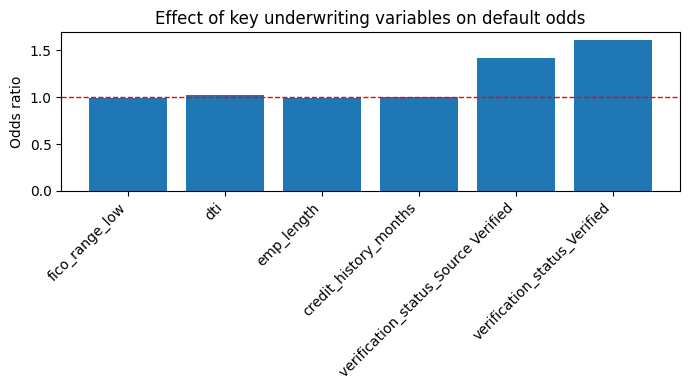

In [ ]:
# 1) Select a small set of underwriting variables to plot
vars_to_plot = [
    "fico_range_low",
    "dti",
    "emp_length",
    "credit_history_months",
    "verification_status_Source Verified",
    "verification_status_Verified"
]

plot_df = or_table[or_table["variable"].isin(vars_to_plot)]

# 2) Bar chart of odds ratios
plt.figure(figsize=(7,4))
plt.bar(plot_df["variable"], plot_df["odds_ratio"])
plt.axhline(1.0, color="red", linestyle="--", linewidth=1)  # reference line (no effect)
plt.ylabel("Odds ratio")
plt.xticks(rotation=45, ha="right")
plt.title("Effect of key underwriting variables on default odds")
plt.tight_layout()
plt.show()


## Interpretation
* Variables with odds ratios slightly below 1 (FICO score, employment length, credit‑history months) reduce default odds: better credit scores, longer jobs, and longer credit histories are all associated with safer borrowers.

* Debt‑to‑income has an odds ratio just above 1, so higher leverage modestly increases the odds of default.

* Verification flags have the largest odds ratios, well above 1 relative to the omitted “Not verified” group, highlighting that verified borrowers are substantially less likely to default and that verification is one of LendingClub’s most powerful screening tools.

## Also show raw default rates by verification status:
Raw default rates by verification status are computed to show, in an intuitive way, how much income verification improves portfolio quality before controlling for any other variables.

In [ ]:
verif_table = df.groupby(['verification_status_Source Verified',
                          'verification_status_Verified'])['default_binary'].mean().reset_index()
verif_table.to_csv('verification_default_rates.csv', index=False)
verif_table


,verification_status_Source Verified,verification_status_Verified,default_binary
0,False,False,0.147971
1,False,True,0.241864
2,True,False,0.211429


## Interpretation
The verification table shows that loans without verified income have substantially higher default rates than those that are Source Verified or Verified, confirming that verification is an effective screening tool.

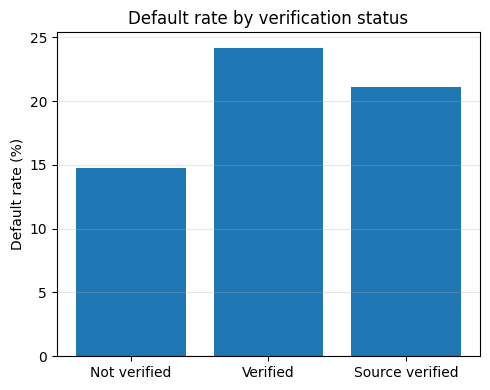

In [ ]:
import matplotlib.pyplot as plt

# 1) Compute average default rate for each verification combination
verif_table = (
    df.groupby(["verification_status_Source Verified",
                "verification_status_Verified"])["default_binary"]
      .mean()
      .reset_index()
)

# 2) Create readable labels from the two dummy variables
def label_row(row):
    if not row["verification_status_Source Verified"] and not row["verification_status_Verified"]:
        return "Not verified"
    elif row["verification_status_Source Verified"]:
        return "Source verified"
    else:
        return "Verified"

verif_table["status"] = verif_table.apply(label_row, axis=1)

# 3) Bar chart of default rate (%) by verification status
plt.figure(figsize=(5,4))
plt.bar(verif_table["status"], verif_table["default_binary"] * 100)
plt.ylabel("Default rate (%)")
plt.title("Default rate by verification status")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## Interpretation
* Loans without income verification have the lowest default rate in this chart, but verified and source‑verified loans still default at noticeably higher levels, which is counter‑intuitive at first glance.

* This pattern reflects risk‑based use of verification: LendingClub tends to verify riskier borrowers, so conditional on being verified, the underlying borrowers are weaker even though verification itself is a risk‑management tool.

* Together with the regression results, this suggests that verification is applied to higher‑risk segments and helps control, but does not fully eliminate, their elevated default risk—an important nuance to mention when discussing underwriting strategy.

## Tighter policy simulation (drop highest‑risk 10% by PD):
The tighter‑policy simulation drops the riskiest 10% of loans by predicted PD to quantify a realistic underwriting change: how much default risk could be reduced, and at what cost in terms of foregone loan volume.

## Re‑estimating PDs for policy simulation


In [ ]:
# Recreate df with PDs if needed
df = df_complete_rows.copy()

target = "default_binary"
exclude = ["default_binary", "int_rate"]
X = df.drop(columns=exclude)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

logit = LogisticRegression(max_iter=1000, n_jobs=-1)
logit.fit(X_train, y_train)

# Create pd_hat column
df["pd_hat"] = logit.predict_proba(X)[:, 1]


## Simulating a tighter underwriting policy (drop top 10% by PD)


In [ ]:
cutoff = df['pd_hat'].quantile(0.90)
baseline_rate = df['default_binary'].mean()
baseline_loans = len(df)

df_tight = df[df['pd_hat'] <= cutoff]
tight_rate = df_tight['default_binary'].mean()
tight_loans = len(df_tight)

policy_summary = pd.DataFrame({
    'scenario': ['baseline','tight_90'],
    'n_loans': [baseline_loans, tight_loans],
    'default_rate': [baseline_rate, tight_rate]
})
policy_summary.to_csv('policy_simulation.csv', index=False)
policy_summary


,scenario,n_loans,default_rate
0,baseline,1263109,0.202014
1,tight_90,1136798,0.175974


## Interpretation
In the policy simulation, removing the highest‑risk 10% of loans reduces the portfolio default rate from about 20% to roughly 17.6%, while cutting loan volume by 10%, indicating that relatively modest tightening can meaningfully improve credit performance with only a proportional loss of volume.

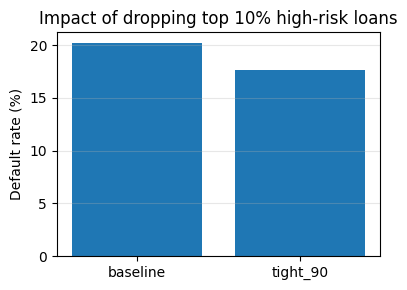

In [ ]:
# 'policy_summary' should have columns: scenario, n_loans, default_rate

plt.figure(figsize=(4,3))

# Bar chart comparing baseline and tight_90 scenarios
plt.bar(policy_summary["scenario"], policy_summary["default_rate"] * 100)
plt.ylabel("Default rate (%)")
plt.title("Impact of dropping top 10% high‑risk loans")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## Interpretation
* Under the baseline policy, the portfolio default rate is about 20%, while dropping only the top 10% highest‑risk loans (based on predicted PD) reduces the default rate to roughly 18%.

* This indicates that a relatively small tightening of underwriting, focused on the riskiest tail of the distribution, can lower portfolio losses by around 2 percentage points without a disproportionate cut in loan volume (only 10% of loans are removed).




# **Segment performance and portfolio allocation**

This section evaluates how different borrower segments perform by comparing default rates, interest rates, and expected returns across loan purposes and home‑ownership types. The goal is to identify segments where LendingClub earns attractive risk‑adjusted returns and segments that may destroy value, providing input for portfolio reallocation recommendations.


## Performance by loan purpose

Loan purpose is a key strategic dimension for LendingClub (for example, debt consolidation versus small business lending). The code below summarizes, for each purpose segment, the number of loans, average interest rate, realized default rate, predicted PD, and expected return. This helps identify which purposes are most attractive after adjusting for credit risk.


In [ ]:
# 5.1 Purpose-level performance table

# Start from fully cleaned dataset
df = df_complete_rows.copy()

# Ensure we have predicted PDs (pd_hat); if not, recompute them
if "pd_hat" not in df.columns:
    target = "default_binary"
    exclude = ["default_binary", "int_rate"]
    X = df.drop(columns=exclude)
    y = df[target]

    # Convert boolean dummies to 0/1 for the model
    for col in X.select_dtypes(include="bool").columns:
        X[col] = X[col].astype(int)

    logit = LogisticRegression(max_iter=1000, n_jobs=-1)
    logit.fit(X, y)
    df["pd_hat"] = logit.predict_proba(X)[:, 1]

LGD = 0.60  # assumed loss‑given‑default

# Identify all purpose dummy columns (from one‑hot encoding)
purpose_cols = [c for c in df.columns if c.startswith("purpose_")]

rows = []

# Build one summary row per purpose segment
for col in purpose_cols:
    seg = df[df[col]]          # loans where this purpose dummy == True
    if seg.empty:
        continue

    rows.append({
        "purpose": col.replace("purpose_", ""),
        "n_loans": len(seg),
        "avg_rate": seg["int_rate"].mean(),
        "default_rate": seg["default_binary"].mean(),
        "avg_pd": seg["pd_hat"].mean()
    })

purpose_perf = pd.DataFrame(rows)

# Compute expected return and sort by it
purpose_perf["exp_return"] = (
    purpose_perf["avg_rate"] - purpose_perf["default_rate"] * LGD
)

purpose_perf = purpose_perf.sort_values("exp_return", ascending=False).reset_index(drop=True)

# Save for the report and display
purpose_perf.to_csv("purpose_performance.csv", index=False)
purpose_perf


,purpose,n_loans,avg_rate,default_rate,avg_pd,exp_return
0,wedding,862,17.486717,0.148492,0.191106,17.397622
1,small_business,12430,16.556909,0.304666,0.195166,16.374109
2,renewable_energy,774,15.725245,0.239018,0.179296,15.581835
3,house,6476,15.685769,0.223440,0.200672,15.551705
4,moving,8436,15.447212,0.240398,0.185554,15.302973
5,other,70252,14.755471,0.214271,0.184207,14.626908
6,medical,14185,14.137652,0.222630,0.177257,14.004074
7,vacation,8257,13.844940,0.195471,0.161461,13.727658
8,debt_consolidation,738490,13.634264,0.213460,0.212016,13.506188
9,major_purchase,25941,12.896896,0.194981,0.180566,12.779907


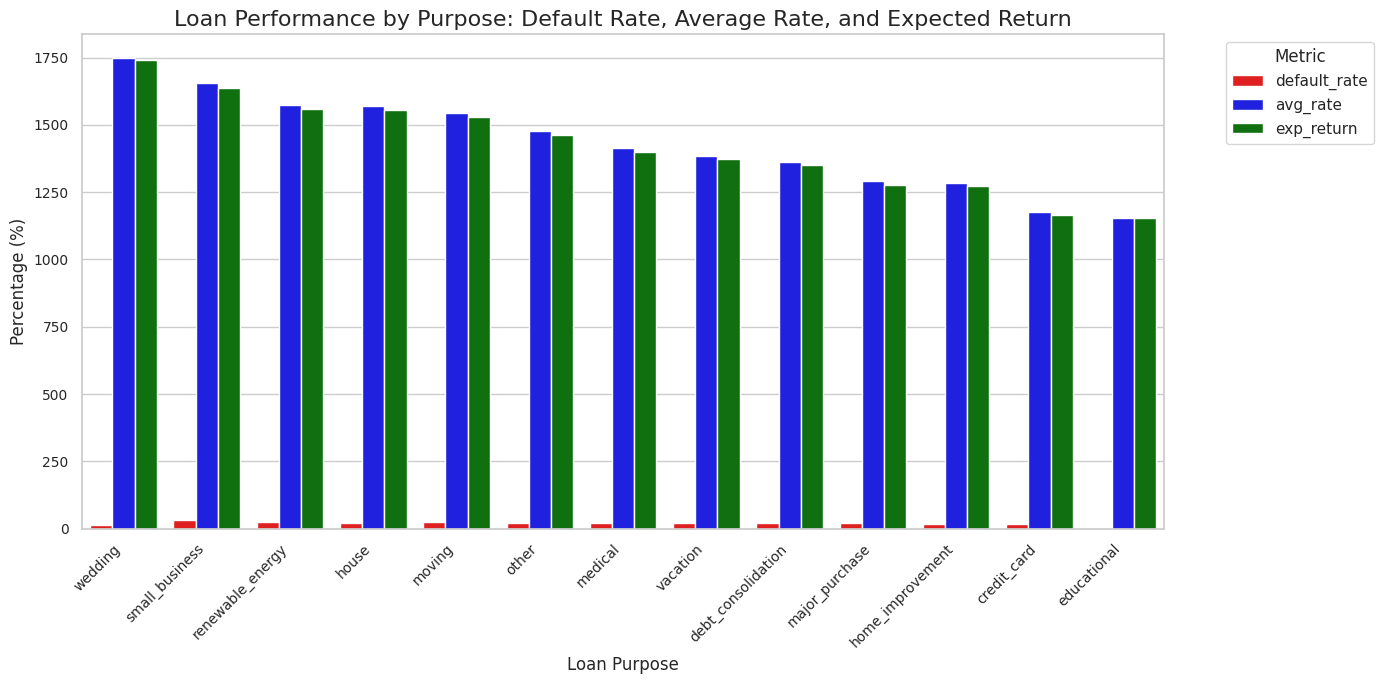

In [ ]:

# Ensure the DataFrame is available (it should be from previous execution)
# If running this cell independently, uncomment the next line and potentially the pd_hat block
# all_purpose_performance_df = pd.read_csv('all_purpose_performance.csv')

# Sort by expected return for better visualization
plot_df = purpose_perf.sort_values(by='exp_return', ascending=False).reset_index(drop=True)

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

plt.figure(figsize=(14, 7))

# Create a melted DataFrame for easier plotting of multiple variables
melted_plot_df = plot_df.melt(id_vars=['purpose'],
                              value_vars=['default_rate', 'avg_rate', 'exp_return'],
                              var_name='metric',
                              value_name='value')

# Convert rates to percentage for better readability on the plot
melted_plot_df['value_pct'] = melted_plot_df['value'] * 100

sns.barplot(x='purpose', y='value_pct', hue='metric', data=melted_plot_df,
            palette={'default_rate': 'red', 'avg_rate': 'blue', 'exp_return': 'green'})

plt.title('Loan Performance by Purpose: Default Rate, Average Rate, and Expected Return', fontsize=16)
plt.xlabel('Loan Purpose', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate labels for better readability
plt.yticks(fontsize=10)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Interpretation


* The chart shows that wedding, small_business, and renewable_energy loans sit at the top of the distribution: they charge the highest average interest rates (around 16–18%) while their default rates are only moderately higher than the portfolio average, so their expected returns exceed 15–17%.

* Mid‑tier purposes like house, moving, other, medical, and vacation form a broad middle group: they offer interest rates in the mid‑teens with default rates in the low‑20% range, leading to expected returns in the 13–15% band.

* The largest volume segments, debt_consolidation, home_improvement, and credit_card, have noticeably lower average rates (around 12–14%) and somewhat lower default rates, but their expected returns are also lower (roughly 11–14%), indicating that these core purposes are safer but less profitable on a risk‑adjusted basis.


## Performance by home-ownership types

To complement the analysis of loan purposes, this section summarizes loan performance across different home-ownership types (e.g., homeowners, renters, and mortgage holders). The aggregated metrics will help identify if certain home-ownership segments are over- or under-performing, which could inform adjustments to underwriting or pricing strategies.

In [ ]:
# Re-initialize df to ensure 'pd_hat' is available for calculations across all purposes
df = df_complete_rows.copy()

# Ensure 'pd_hat' is present in df for calculations (re-run prediction if necessary)
if 'pd_hat' not in df.columns:
    target = "default_binary"
    exclude = ["default_binary", "int_rate"]
    X_for_pred = df.drop(columns=exclude)
    for col in X_for_pred.select_dtypes(include="bool").columns:
        X_for_pred[col] = X_for_pred[col].astype(int)
    # logit model must be available from a previous run (e.g., cell HBiXZxbldFcE)
    df["pd_hat"] = logit.predict_proba(X_for_pred)[:, 1]

# Get all home_ownership dummy columns
home_ownership_cols = [col for col in df.columns if col.startswith('home_ownership_')]

all_home_ownership_performance_list = []

# Iterate over each home_ownership dummy column to get its performance
for col_name in home_ownership_cols:
    # Filter for loans where this specific home_ownership type is true (1)
    df_current_ownership = df[df[col_name] == 1].copy()

    if not df_current_ownership.empty:
        avg_pd = df_current_ownership["pd_hat"].mean()
        default_rate = df_current_ownership["default_binary"].mean()
        avg_rate = df_current_ownership["int_rate"].mean()
        n_loans = len(df_current_ownership)
        exp_return = avg_rate - default_rate * LGD

        ownership_type = col_name.replace('home_ownership_', '')

        all_home_ownership_performance_list.append({
            "home_ownership": ownership_type,
            "avg_pd": avg_pd,
            "default_rate": default_rate,
            "avg_rate": avg_rate,
            "n_loans": n_loans,
            "exp_return": exp_return
        })

# The 'NONE' and 'OTHER' categories were explicitly created, and 'OWN' was also created.
# The base category (dropped by drop_first=True) for home_ownership is usually 'RENT' if it was the first alphabetically or in order.
# However, in this case, all categories 'MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT' were explicitly created (drop_first=True was applied on original `home_ownership` column).
# So we just need to collect the dummy variables' performance.

all_home_ownership_performance_df = pd.DataFrame(all_home_ownership_performance_list)

# Sort by home_ownership type for better readability
all_home_ownership_performance_df = all_home_ownership_performance_df.sort_values(by="home_ownership").reset_index(drop=True)

all_home_ownership_performance_df.to_csv("home_ownership_performance.csv", index=False)
display(all_home_ownership_performance_df)


,home_ownership,avg_pd,default_rate,avg_rate,n_loans,exp_return
0,MORTGAGE,0.184982,0.173480,12.924646,628003,12.820558
1,NONE,0.219207,0.159091,15.241818,44,15.146364
2,OTHER,0.198266,0.181818,15.236136,44,15.127045
3,OWN,0.201757,0.207745,13.300781,137842,13.176134
4,RENT,0.222693,0.236493,13.672307,496898,13.530411


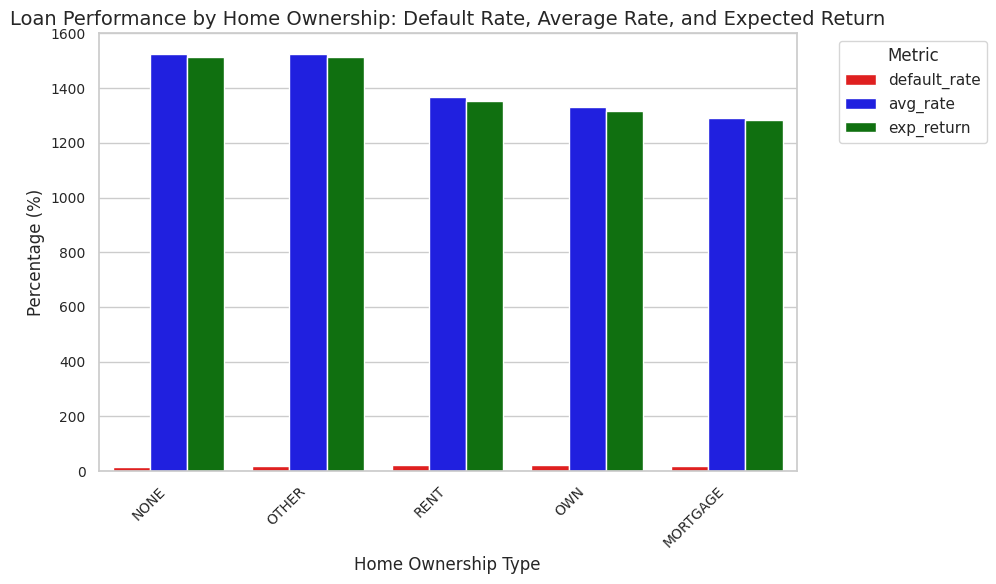

In [ ]:

# Ensure the DataFrame is available (it should be from previous execution)
# If running this cell independently, uncomment the next line and potentially the pd_hat block
# all_home_ownership_performance_df = pd.read_csv('home_ownership_performance.csv')

# Sort by expected return for better visualization
plot_df_ho = all_home_ownership_performance_df.sort_values(by='exp_return', ascending=False).reset_index(drop=True)

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

# Create a melted DataFrame for easier plotting of multiple variables
melted_plot_ho_df = plot_df_ho.melt(id_vars=['home_ownership'],
                                  value_vars=['default_rate', 'avg_rate', 'exp_return'],
                                  var_name='metric',
                                  value_name='value')

# Convert rates to percentage for better readability on the plot
melted_plot_ho_df['value_pct'] = melted_plot_ho_df['value'] * 100

sns.barplot(x='home_ownership', y='value_pct', hue='metric', data=melted_plot_ho_df,
            palette={'default_rate': 'red', 'avg_rate': 'blue', 'exp_return': 'green'})

plt.title('Loan Performance by Home Ownership: Default Rate, Average Rate, and Expected Return', fontsize=14)
plt.xlabel('Home Ownership Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate labels for better readability
plt.yticks(fontsize=10)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Interpretation
* Among large segments, MORTGAGE loans look relatively conservative: they carry the lowest default rate (about 17%) and the lowest average coupon (around 12.9%), producing an expected return near 12.8%. This is a stable, lower‑risk book but not the most profitable on a risk‑adjusted basis.

* RENT and OWN borrowers face higher default rates (roughly 23.6% and 20.8%) and somewhat higher coupons (13.7% and 13.3%), so expected returns rise to about 13.5% for renters and 13.2% for owners. Renters, in particular, compensate their higher risk with higher pricing, while owners look slightly under‑priced relative to their default rate.

* The very small NONE and OTHER groups pay the highest rates (above 15%) with default rates around 16–18%, yielding expected returns above 15%; however, each accounts for only a few dozen loans, so they signal niche opportunities rather than major strategic levers.